In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
from scipy.integrate import quad, dblquad
from scipy.linalg import eig, eigh, toeplitz, cholesky
from scipy import sparse


In [2]:
"""SPDE settings"""

"""Condition"""
t0, T = 0, 1  # time (min, max)
a, b = 0, 1  # space (min, max)
X0 = lambda x: None if not (0 <= x <= 1) else 1 - 2 * abs(x - 0.5)

"""Scalar products and norms"""
scal = lambda f, g: quad(func=lambda x: f(x) * g(x), a=a, b=b)[
    0
]  # scalar product of L2
phi = lambda f: scal(f, f)
phi_basis = lambda x, M: x.T.dot(M).dot(
    x
)  # non linear functionnal to evaluate - L2-norm

"""Covariance kernel"""
lambdas = np.array([25, 25])
f1 = lambda x: x ** (-0.45)
f2 = lambda x: (1 - x) ** (-0.45)
q = lambda x, y: lambdas[0] * f1(x) * f1(y) + lambdas[1] * f2(x) * f2(y)


In [3]:
"""Helpers functions"""
interp1d = lambda X, nodes: np.array([X(node) for node in nodes])
interp2d = lambda X, nodes1, nodes2: np.array(
    [[X(node1, node2) for node2 in nodes2] for node1 in nodes1]
)


In [54]:
def helper_solver(h, N_h, dt, X0=X0, q=q):
    """Interpolation basis of functions"""
    nodes = tuple(k * h for k in range(0, N_h + 2))  # nodes

    interp_nodes = nodes[1:-1]  # nodes of interpolation

    basis_tent_func = tuple(
        lambda x, node=node: None
        if not (0 <= x <= 1)
        else max(1 - abs(x - node) / h, 0)
        for node in interp_nodes
    )

    """Matrices of Euler-Maruyama scheme"""
    M_h = toeplitz(
        (
            sparse.csr_array(
                ([2 / 3, 1 / 6], ([0, 1], [0, 0])), shape=(N_h, 1)
            )
            * h
        ).toarray()
    )  # mass matrix
    A_h = toeplitz(
        (
            sparse.csr_array(([2, -1], ([0, 1], [0, 0])), shape=(N_h, 1)) / h
        ).toarray()
    )  # stiffness matrix

    R_h = M_h + dt * A_h  # ritz projection matrix

    R_h_inv = np.linalg.inv(R_h)  # ritz projection matrix inverse

    x0 = interp1d(X0, interp_nodes)  # initial projected value

    """Covariance matrix associated to the Q-Wiener process"""
    Sigma_h_d0 = np.array(
        [
            dblquad(lambda x, y: q(x, y) * Phi(x) * Phi(y), 0, 1, 0, 1)[0]
            for Phi in basis_tent_func
        ]
    )

    Sigma_h_d1 = np.array(
        [
            dblquad(
                lambda x, y: q(x, y)
                * basis_tent_func[k](x)
                * basis_tent_func[k + 1](y),
                0,
                1,
                0,
                1,
            )[0]
            for k in range(N_h - 1)
        ]
    )

    Sigma_h = dt * (
        sparse.diags(
            diagonals=[Sigma_h_d1, Sigma_h_d0, Sigma_h_d1], offsets=[-1, 0, +1]
        ).toarray()
        + (eps := 1e-8) * np.eye(N_h)
    )

    return x0, M_h, R_h_inv, Sigma_h, nodes, basis_tent_func


In [5]:
def plot_traj(data, N_dt, nodes):
    plt.figure(figsize=(5, 5))
    T = np.linspace(0, 1, N_dt)
    colorbar = plt.contourf(T, nodes, data.T, cmap="coolwarm")
    plt.xlabel(r"$t \in [0, 1]$")
    plt.ylabel(r"$x \in [0, 1]$")
    plt.colorbar(colorbar)
    plt.show()


In [6]:
def EM(x0, M1, M2, N_dt, verbose=False, nodes=None):
    """Iteration of Euler-Maruyama scheme"""

    x = x0.copy()

    if verbose:
        data = np.empty((N_dt, len(x0) + 2))
        data[..., 0] = data[..., -1] = np.zeros(N_dt)
        data[0, 1:-1] = x0

    for j in range(N_dt - 1):
        x = M1.dot(x) + M2[..., j]  # resolution of EM system
        if verbose:
            data[(j + 1), 1:-1] = x

    if verbose:
        plot_traj(data, N_dt, nodes)

    return x


In [7]:
def algo1(n_iter : int, H):
    """1st algo - path-based + MC"""
    
    L = len(H)
    
    results_algo1 = np.empty((n_iter, L))
        
    for i in range(n_iter):
        for l, h in enumerate(H):
            N, N_dt, N_h = (
                int(min(1000, h**-4)),
                int(1 / (dt := h**2) + 1),
                int(h**-1 - 1),
            )  # #samples, #time-steps, #nodes (of interpolation)
                
            x0, M_h, R_h_inv, Sigma_h, _, _ = helper_solver(h, N_h, dt)

            C = cholesky(Sigma_h + (eps := 1e-5) * np.eye(N_h)) # cholesky of the covariance matrix

            M1 = R_h_inv.dot(M_h) # useful matrix precomputed

            """Computation of expected functionnal of 
            the stoch. process. under the SPDE 
            at time T by MC estim."""
            result = 0
            for m in range(N):

                """Simulation of Q-Wiener process deltas"""
                s = int(str(i) + str(m))
                npr.seed(s)  # fix the seed
                dW = C.dot(npr.standard_normal((N_h, N_dt)))

                M2 = R_h_inv.dot(dW) # useful matrix precomputed
                
                x = EM(x0, M1, M2, N_dt)

                result += (
                    phi_basis(x, M_h) / N
                )  # MC estim. computation
                
            results_algo1[i, l] = result
            
    return results_algo1


In [8]:
def algo2(n_iter : int , H : list):
    """2nd algo - cov-based + MC"""
    
    L = len(H)
    results_algo2 = np.empty((n_iter, L))
    for i in range(n_iter):
        for l, h in enumerate(H):
            N, N_dt, N_h = (
                int(min(h**-4, 100)),
                int(1 / (dt := h**2) + 1),
                int(h**-1 - 1),
            )  # #samples, #time-steps, #nodes (of interpolation)

            x0, M_h, R_h_inv, Sigma_h, _, _ = helper_solver(h, N_h, dt)

            # Usefull helper matrices to solve the system
            M1 = R_h_inv.dot(M_h)
            M2 = R_h_inv.dot(Sigma_h).dot(R_h_inv)

            Sigma_h_x = np.empty(M1.shape)
            mu_x = x0
            for _ in range(N_dt - 1):
                Sigma_h_x = (
                    M1.dot(Sigma_h_x).dot(M1.T) + M2
                )  # resolution of cov scheme
                mu_x = M1.dot(mu_x)

            M = int(np.log(N_h))
            Sigma_h_x += (eps := 1e-5) * np.eye(N_h)
            eigenvalues, eigenvectors = eigh(
                Sigma_h_x, subset_by_index=[N_h - M, N_h - 1]
            )
            E = np.sqrt(eigenvalues) * eigenvectors

            """Computation of expected functionnal of 
            the stoch. process. under the SPDE 
            at time T by MC estim."""
            result = 0
            for m in range(N):

                """Simulation of Q-Wiener process deltas"""
                s = int(str(i) + str(m)) # seed
                npr.seed(s)  # fix the seed
                x = mu_x + E.dot(npr.standard_normal(M))  # by trunc. KL exp.

                result += phi_basis(x, M_h) / N  # MC estim. computation

            results_algo2[i, l] = result

    return results_algo2


In [9]:
def algo3(n_iter: int, H : list):
    """3rd algo - path-based + MLMC"""
    L = len(H)
    results_algo3 = np.empty((n_iter, L))
    for i in range(n_iter):
        result = 0
        for l in range(L):

            dt = (
                N_dt := (
                    N_h := (
                        x0 := (
                            M_h := (
                                R_h_inv := (
                                    Sigma_h := (
                                        nodes := (
                                            C := (M1 := [np.array([])] * 2)[:]
                                        )[:]
                                    )[:]
                                )[:]
                            )[:]
                        )[:]
                    )[:]
                )[:]
            )[:]
            for j in range(2):
                if l + j - 1 < 0:
                    continue

                dt[j] = (h := H[l + j - 1]) ** 2

                N_dt[j], N_h[j] = (
                    int(1 / dt[j] + 1),
                    int(h**-1 - 1),
                )  # #samples, #time-steps, #nodes (of interpolation)

                (
                    x0[j],
                    M_h[j],
                    R_h_inv[j],
                    Sigma_h[j],
                    _, 
                    _
                ) = helper_solver(h, N_h[j], dt[j])

                C[j] = cholesky(Sigma_h[j] + (eps := 1e-5) * np.eye(N_h[j]))

                M1[j] = R_h_inv[j].dot(M_h[j])

            N_l = int(
                min(
                    1000,
                    np.ceil((h_L := H[-1]) ** -4)
                    if l == 0
                    else np.ceil(
                        h_L**-4
                        * (h_l := H[l]) ** 2
                        * (l + 1) ** (1 + (eps := 1e-5))
                    ),
                )
            )

            """Computation of expected functionnal of 
            the stoch. process. under the SPDE 
            at time T by MC estim."""
            for m in range(N_l):
                """Simulation of Q-Wiener process deltas"""
                s = int(str(i) + str(m))
                npr.seed(s)  # fix the seed
                dksi = npr.standard_normal((N_h[1], N_dt[1] - 1))

                for j in range(2):
                    if l + j - 1 < 0:
                        continue

                    K = 1 if j == 1 else int(dt[0] // dt[1])

                    dW = C[j].dot(dksi[: N_h[j], ::K])
                    M2 = R_h_inv[j].dot(dW)
                    result += (
                        (-1) ** (j + 1)
                        * phi_basis(
                            EM(x0[j], M1[j], M2, N_dt[j]),
                            M_h[j],
                        )
                        / N_l
                    )

            results_algo3[i, l] = result

    return results_algo3


In [10]:
def algo4(n_iter, H: list):
    """4th algo - cov-based + MLMC"""
    L = len(H)
    results_algo4 = np.empty((n_iter, L))
    for i in range(n_iter):
        result = 0
        for l in range(L):

            dt = (
                N_dt := (
                    N_h := (
                        M1 := (
                            M2 := (
                                R_h_inv := (
                                    mu_x := (
                                        nodes := (
                                            Sigma_h_x := (
                                                M_h := [np.array([])] * 2
                                            )[:]
                                        )[:]
                                    )[:]
                                )[:]
                            )[:]
                        )[:]
                    )[:]
                )[:]
            )[:]
            for j in range(2):
                if l + j - 1 < 0:
                    continue

                dt[j] = (h := H[l + j - 1]) ** 2

                N_dt[j], N_h[j] = (
                    int(1 / dt[j] + 1),
                    int(h**-1 - 1),
                )  # #samples, #time-steps, #nodes (of interpolation)

                (
                    mu_x[j],
                    M_h[j],
                    R_h_inv[j],
                    Sigma_h,
                    nodes[j], 
                    _
                ) = helper_solver(h, N_h[j], dt[j])

                # Usefull helper matrices to solve the system
                M1[j] = R_h_inv[j].dot(M_h[j])
                M2 = R_h_inv[j].dot(Sigma_h).dot(R_h_inv[j])

                Sigma_h_x[j] = np.empty(M1[j].shape)
                for _ in range(N_dt[j] - 1):
                    Sigma_h_x[j] = (
                        M1[j].dot(Sigma_h_x[j]).dot(M1[j].T) + M2
                    )  # resolution of EM system
                    mu_x[j] = M1[j].dot(mu_x[j])

                Sigma_h_x[j] + (eps := 1e-5) * np.eye(N_h[j])

            mu: np.ndarray
            E: np.ndarray
            if l == 0:

                mu = mu_x[1]

                M = int(np.log(N_h[1]))

                eigenvalues, eigenvectors = eigh(
                    Sigma_h_x[1], subset_by_index=[N_h[1] - M, N_h[1] - 1]
                )

                E = np.sqrt(eigenvalues) * eigenvectors

            else:
                """Covariance matrix associated to the Q-Wiener process"""

                Sigma_h_cross = dt[1] * (
                    M_h[1]
                    .dot(interp2d(q, nodes[1][1:-1], nodes[0][1:-1]))
                    .dot(M_h[0])
                ) + (eps := 1e-5) * np.eye(N_h[1], N_h[0])

                M2 = R_h_inv[1].dot(Sigma_h_cross).dot(R_h_inv[0])

                K = int(dt[0] // dt[1])
                Sigma_x_cross = np.zeros(Sigma_h_cross.shape)
                for j in range(N_dt[1] - 1):
                    if (j + 1 % K) == 0:
                        Sigma_x_cross = (
                            M1[1].dot(Sigma_x_cross).dot(M1[0].T) + M2
                        )

                Sigma_x = np.block(
                    [
                        [Sigma_h_x[0], Sigma_x_cross.T],
                        [Sigma_x_cross, Sigma_h_x[1]],
                    ]
                )

                mu = np.hstack((mu_x[0], mu_x[1]))

                # Sigma_x += (eps := 1e-3) * np.eye(N_h[0] + N_h[1])

                M = int(np.log(N_h[0] + N_h[1]))
                eigenvalues, eigenvectors = eigh(
                    Sigma_x,
                    subset_by_index=[N_h[0] + N_h[1] - M, N_h[0] + N_h[1] - 1],
                )

                E = np.sqrt(eigenvalues) * eigenvectors

            N_l = int(
                min(
                    1e4,
                    np.ceil((h_L := H[-1]) ** -4)
                    if l == 0
                    else np.ceil(
                        h_L**-4
                        * (h_l := H[l]) ** 2
                        * (l + 1) ** (1 + (eps := 1e-5))
                    ),
                )
            )

            """Computation of expected functionnal of 
            the stoch. process. under the SPDE 
            at time T by MC estim."""
            for m in range(N_l):

                """Simulation of Q-Wiener process deltas"""
                s = int(str(i) + str(m))
                npr.seed(s)  # fix the seed

                xx = mu + E.dot(npr.standard_normal(M))  # by trunc. KL exp.

                for j in range(2):
                    if l + j - 1 < 0:
                        continue

                    x = xx[: N_h[j]] if j == 0 else xx[-N_h[j] :]
                    result += (-1) ** (j + 1) * phi_basis(x, M_h[j]) / N_l

            results_algo4[i, l] = result

    return results_algo4


In [11]:
def algoref(h = 2**-7):
    """Deterministic method"""
    
    N, N_dt, N_h = (
        int(min(h**-4, 1e4)),
        int(1 / (dt := h**2) + 1),
        int(h**-1 - 1),
    )  # #samples, #time-steps, #nodes (of interpolation)

    x0, M_h, R_h_inv, Sigma_h, _, _ = helper_solver(h, N_h, dt)

    # Usefull helper matrices (precomputed)
    M1 = R_h_inv.dot(M_h)
    M2 = R_h_inv.dot(Sigma_h ).dot(R_h_inv)

    Sigma_h_x = np.empty(M1.shape)
    mu_x = x0
    for _ in range(N_dt - 1):
        Sigma_h_x = (
            M1.dot(Sigma_h_x).dot(M1.T) + M2
        )  # resolution of cov scheme
        mu_x = M1.dot(mu_x)
        
    mu2_x = Sigma_h + np.kron(mu_x, mu_x).reshape((N_h, N_h))

    return (mu2_x * M_h).sum()


In [113]:
algoref()

7.315492376527737e-07

In [116]:
results_algoref = 7.315492376527737e-07

In [154]:
"""Spatial mesh ranges"""
H1 = list(2**i for i in range(-2, -6, -1))  
H2 = list(2**i for i in range(-2, -8, -1))
H3 = list(2**i for i in range(-2, -7, -1))
H4 = H2

In [118]:
n_iter = 5

In [ ]:
results_algo_MC = []
for i, H, algo in zip([0, 1], [H1, H2], [algo1, algo2]):
    results_algo_MC.append(algo(n_iter, H))
    
    print(f"Résultats de l'algo n°{i+1}\n{results_algo_MC[i]}")
          


In [ ]:
results_algo1 = np.array(
    [
        [1.37138188, 0.98380857, 0.57097657, 0.26238162],
        [1.31272529, 0.98669578, 0.57420598, 0.26743936],
        [1.25572852, 0.98882809, 0.57423088, 0.26656752],
        [1.41130539, 0.98354104, 0.57458037, 0.26212724],
        [1.46235799, 0.97088708, 0.57003239, 0.26750063],
    ]
)

results_algo2 = [
    [1.14212492, 0.65720385, 0.44724566, 0.21474964, 0.06640492, 0.01189518],
    [1.22118405, 0.69348181, 0.45076073, 0.21711953, 0.06541477, 0.0117092],
    [1.07690945, 0.65304699, 0.45576741, 0.21758186, 0.06577595, 0.01176932],
    [1.1097374, 0.66290876, 0.4477291, 0.22034024, 0.0671999, 0.01203222],
    [1.14462551, 0.68365261, 0.45750549, 0.21470785, 0.06659278, 0.01192799],
]


In [ ]:
results_algo_MLMC = []
for i, H, algo in zip([0, 1], [H3, H4], [algo3, algo4]):    
    results_algo_MLMC.append(algo(n_iter, H))
        
    print(f"Résultats de l'algo n°{i+3}\n{results_algo_MLMC[i]}")

In [ ]:
results_algo3 = [
    [1.4322517, 0.94421306, 0.53131651, 0.22235736],
    [1.42672937, 0.99691392, 0.56997825, 0.27995922],
    [1.4424006, 0.99402232, 0.60630776, 0.30044673],
    [1.4578451, 0.9802089, 0.57697431, 0.27235692],
    [1.40904982, 0.94132163, 0.52953625, 0.22222609],
]


In [ ]:
err_quad = lambda results, val_ref: np.sqrt(((results - np.array([val_ref]))**2).mean(axis=0))

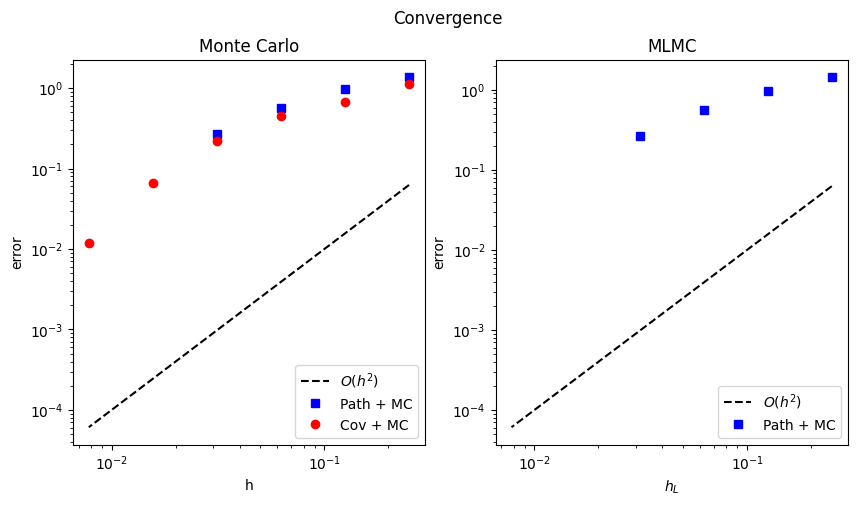

In [ ]:
H1 = list(2**i for i in range(-2, -6, -1))  # mesh range
H2 = list(2**i for i in range(-2, -8, -1))

fig = plt.figure(figsize=(10, 5))

"""Plot convergence of the quadratic error for several MC estimators and methods"""
fig.suptitle("Convergence")

plt.subplot(121)

"""Monte Carlo estimator"""
plt.title("Monte Carlo")

plt.ylabel("error")
plt.xlabel("h")

plt.xscale('log')
plt.yscale('log')

plt.plot(H2, np.array(H2)**2, "--k")

for H, results, m in zip([H1, H2], results_algo_MC, ["bs", "ro"]):
    plt.plot(H, err_quad(results, results_algoref), m)

plt.legend([r"$O(h^2)$", "Path + MC", "Cov + MC"], loc="lower right")


"""Multi Level Monte Carlo"""
plt.subplot(122)

plt.title("MLMC")

plt.ylabel("error")
plt.xlabel(r"$h_L$")

plt.xscale('log')
plt.yscale('log')

plt.plot(H2, np.array(H2)**2, "--k")

for H, results, m in zip([H3, H4], results_algo_MLMC, ["bs", "ro"]):
    plt.plot(H, err_quad(results, results_algoref), m)

plt.legend([r"$O(h^2)$", "Path + MC", "Cov + MC"], loc="lower right")

In [58]:
def algoextra():
    """1st algo - path-based + MC"""
    
    H = list(2**i for i in range(-2, -6, -1))  # mesh range
    H.insert(0, (2**-8))
        
    L = len(H)
    
    results = np.empty((L - 1))
    
    x_ref : np.ndarray
            
    for l, h in enumerate(H):
        N, N_dt, N_h = (
            100,
            int(1 / (dt := h**2) + 1),
            int(h**-1 - 1),
        )  # #samples, #time-steps, #nodes (of interpolation)
        
        if l == 0:
            N = 1
            
        x0, M_h, R_h_inv, Sigma_h, nodes, basis_tent_func = helper_solver(h, N_h, dt)

        C = cholesky(Sigma_h) # cholesky of the covariance matrix

        M1 = R_h_inv.dot(M_h) # useful matrix precomputed

        """Computation of expected functionnal of 
        the stoch. process. under the SPDE 
        at time T by MC estim."""
        result = 0
        for m in range(N):

            """Simulation of Q-Wiener process deltas"""
            s = int(str(m))
            npr.seed(s)  # fix the seed
            dW = C.dot(npr.standard_normal((N_h, N_dt)))

            M2 = R_h_inv.dot(dW) # useful matrix precomputed
            
            x = EM(x0, M1, M2, N_dt, verbose=m==0, nodes=nodes)
                       
            if l==0:
                x_ref = lambda y: sum(k * Phi(y) for k, Phi in zip(x, basis_tent_func))
            else:   
                result += (
                    phi(lambda y: x_ref(y) - sum(k * Phi(y) for k, Phi in zip(x, basis_tent_func)) / N)
                )  # MC estim. computation
                
        if l!=0:
            results[l-1] = np.sqrt(result)

    return results


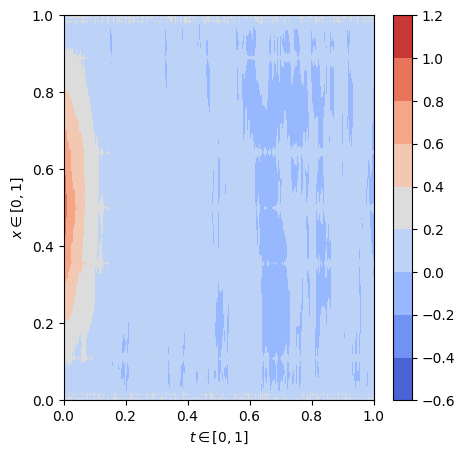

LinAlgError: 3-th leading minor of the array is not positive definite

In [60]:
results = algoextra()

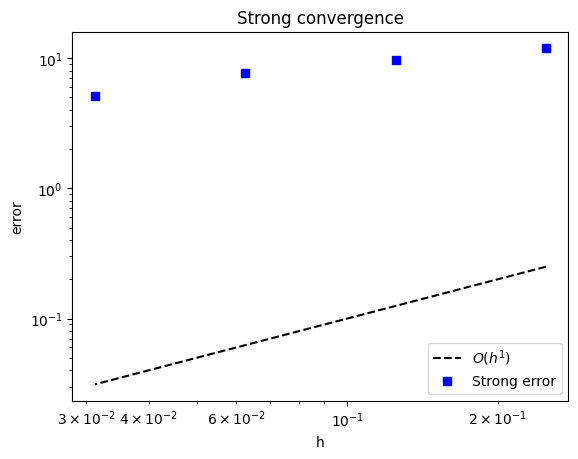

In [ ]:
H1 = list(2**i for i in range(-2, -6, -1))  # mesh range
"""Monte Carlo estimator of the strong error"""
plt.title("Strong convergence")

plt.ylabel("error")
plt.xlabel("h")

plt.xscale('log')
plt.yscale('log')

plt.plot(H1, np.array(H1)**1, "--k")
plt.plot(H1, results, "bs")

plt.legend([r"$O(h^1)$", "Strong error",], loc="lower right")